In [1]:
pip install numpy pandas librosa soundfile scikit-learn matplotlib tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Found 2880 wav files.
X shape (num_samples, features, time): (2880, 120, 174)
Emotions in data: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Train shape: (2304, 120, 174, 1) (2304, 8)
Test shape: (576, 120, 174, 1) (576, 8)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 174, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 174, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 120, 174, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 87, 32)        0         
 D)                                                              
       

c:\Users\manav\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 49s 757ms/step - loss: 1.5645 - accuracy: 0.4202 - val_loss: 1.9370 - val_accuracy: 0.2121
Epoch 3/40
65/65 [==============================] - 54s 831ms/step - loss: 1.3585 - accuracy: 0.4988 - val_loss: 1.8535 - val_accuracy: 0.2857
Epoch 4/40
65/65 [==============================] - 58s 900ms/step - loss: 1.2196 - accuracy: 0.5707 - val_loss: 2.1161 - val_accuracy: 0.2208
Epoch 5/40
65/65 [==============================] - 50s 770ms/step - loss: 1.0912 - accuracy: 0.6025 - val_loss: 1.6964 - val_accuracy: 0.3290
Epoch 6/40
65/65 [==============================] - 50s 777ms/step - loss: 0.9476 - accuracy: 0.6643 - val_loss: 1.5773 - val_accuracy: 0.3939
Epoch 7/40
65/65 [==============================] - 41s 628ms/step - loss: 0.8182 - accuracy: 0.7072 - val_loss: 1.3228 - val_accuracy: 0.4545
Epoch 8/40
65/65 [==============================] - 44s 680ms/step - loss: 0.6962 - accuracy: 0.7612 - val_loss: 1.8147 - val_accuracy: 0.3550
Epoch 9/40

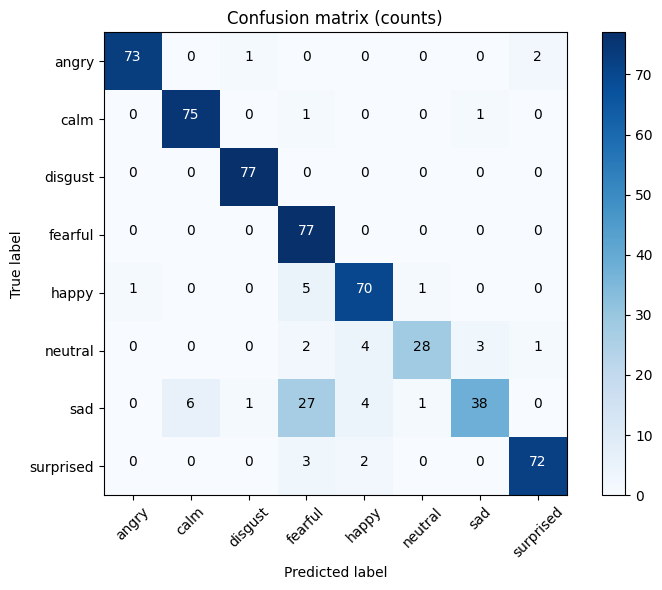

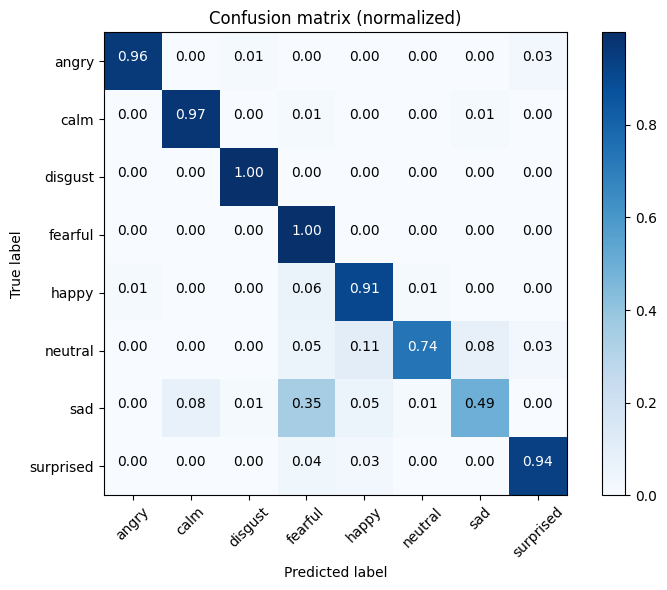

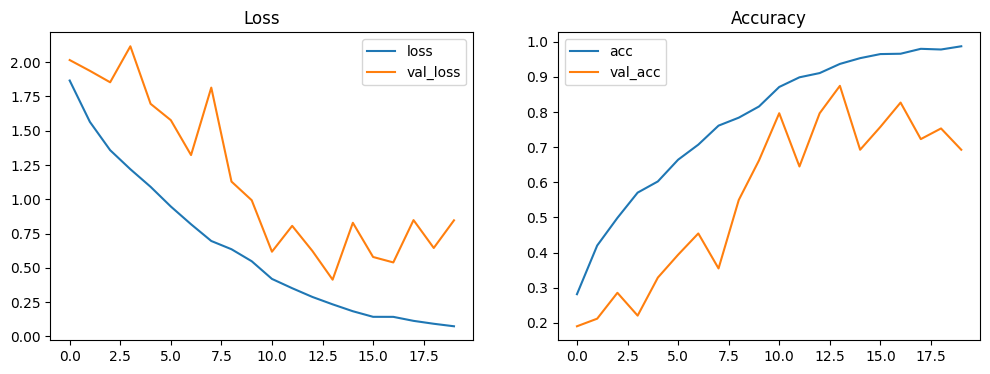

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import itertools
import joblib



# --------- CONFIG ----------
#import drive
# from google.colab import drive
# drive.mount('/content/drive')


DATA_PATH = "../data/kaggle_speech"   # <-- set this to where your WAV files are
SR = 22050                    # sampling rate for librosa.load
N_MFCC = 40                   # number of MFCC coefficients
MAX_PAD_LEN = 174             # number of time frames to pad/truncate to (tunable)
BATCH_SIZE = 32
EPOCHS = 40
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_OUT = "ravdess_ser_cnn.h5"
LABEL_ENCODER_OUT = "ravdess_le.pkl"
# ---------------------------

# RAVDESS emotion mapping (filename 3rd field)
EMOTIONS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_emotion_from_filename(filename):
    # filename is e.g. .../03-01-05-01-02-01-12.wav
    base = os.path.basename(filename)
    parts = base.split('.')[0].split('-')
    if len(parts) < 3:
        return None
    emo_code = parts[2]
    return EMOTIONS.get(emo_code)

def pad_or_truncate(mfcc, max_len=MAX_PAD_LEN):
    # mfcc shape: (n_mfcc, time)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

def extract_features(file_path, sr=SR, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    # load audio
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    # compute MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # compute deltas
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # stack MFCC + delta + delta2 (resulting in channels = 3)
    stacked = np.vstack([mfcc, delta, delta2])  # shape (n_mfcc*3, time)
    # pad / truncate in time dimension
    stacked = pad_or_truncate(stacked, max_pad_len)
    return stacked



def load_dataset(data_path):
    pattern = os.path.join(data_path, '**', '*.wav')
    files = glob.glob(pattern, recursive=True)
    print(f"Found {len(files)} wav files.")
    X, Y = [], []
    for f in files:
        emo = extract_emotion_from_filename(f)
        if emo is None:
            continue
        feat = extract_features(f)
        if feat is None:
            continue
        X.append(feat)
        Y.append(emo)
    X = np.array(X)
    Y = np.array(Y)
    print("X shape (num_samples, features, time):", X.shape)
    return X, Y

def build_cnn_model(input_shape, num_classes):
    # input_shape: (channels, time) where channels = n_mfcc*3
    # We'll treat input as "image" with shape (channels, time, 1)
    inp = layers.Input(shape=(input_shape[0], input_shape[1], 1))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}"
        plt.text(j, i, val,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def main():
    X, Y = load_dataset(DATA_PATH)

    # limit classes if you want (example: use only a subset). Here we use all 8 emotions.
    labels = np.unique(Y)
    print("Emotions in data:", labels)

    # reshape X for CNN: currently (N, features, time) -> convert to (N, features, time, 1)
    X = X[..., np.newaxis]

    # encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(Y)
    num_classes = len(le.classes_)
    y_cat = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

    joblib.dump(le, LABEL_ENCODER_OUT)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
    )

    print("Train shape:", X_train.shape, y_train.shape)
    print("Test shape:", X_test.shape, y_test.shape)

    # build model
    input_shape = (X.shape[1], X.shape[2])  # (features, time)
    model = build_cnn_model((input_shape[0], input_shape[1]), num_classes)
    model.summary()

    # callbacks
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        callbacks.ModelCheckpoint(MODEL_OUT, save_best_only=True, monitor='val_loss')
    ]

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=cb,
        verbose=1
    )

    # evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")


    cnn_result = {'Model': 'CNN', 'Test Accuracy': acc, 'Test Loss': loss}


    # predictions and classification report
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    print("Classification report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

    # confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plot_confusion_matrix(cm, classes=le.classes_, normalize=False, title='Confusion matrix (counts)')
    plot_confusion_matrix(cm, classes=le.classes_, normalize=True, title='Confusion matrix (normalized)')

    # plot training history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

if __name__ == "__main__":
    main()

In [5]:
import joblib
joblib.dump(le, "../models/CNN_label_encoder.pkl")

NameError: name 'le' is not defined

Found 2880 wav files.
X shape (num_samples, features, time): (2880, 120, 174)
Loading trained model from ../models/ravdess_ser_cnn.h5 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 174, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 174, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 120, 174, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 87, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 87, 64)        

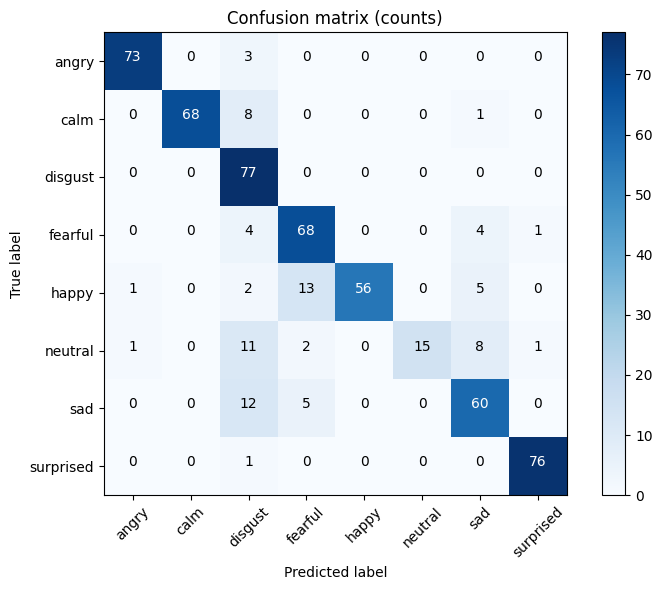

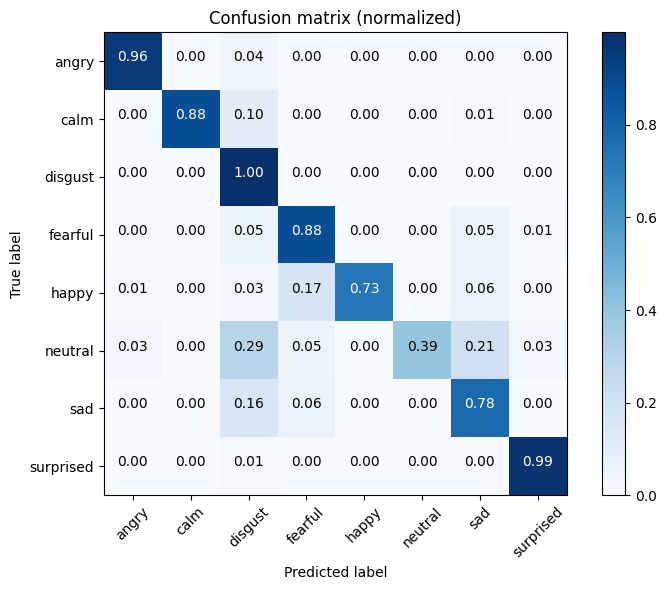

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import models
import matplotlib.pyplot as plt
import itertools
import joblib

# --------- CONFIG ----------
DATA_PATH = "../data/kaggle_speech"   # set this to where your WAV files are
SR = 22050
N_MFCC = 40
MAX_PAD_LEN = 174
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_OUT = "../models/ravdess_ser_cnn.h5"
LABEL_ENCODER_OUT = "../models/ravdess_label_encoder.pkl"
# ---------------------------

# RAVDESS emotion mapping (filename 3rd field)
EMOTIONS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_emotion_from_filename(filename):
    base = os.path.basename(filename)
    parts = base.split('.')[0].split('-')
    if len(parts) < 3:
        return None
    emo_code = parts[2]
    return EMOTIONS.get(emo_code)

def pad_or_truncate(mfcc, max_len=MAX_PAD_LEN):
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

def extract_features(file_path, sr=SR, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    stacked = np.vstack([mfcc, delta, delta2])
    stacked = pad_or_truncate(stacked, max_pad_len)
    return stacked

def load_dataset(data_path):
    pattern = os.path.join(data_path, '**', '*.wav')
    files = glob.glob(pattern, recursive=True)
    print(f"Found {len(files)} wav files.")
    X, Y = [], []
    for f in files:
        emo = extract_emotion_from_filename(f)
        if emo is None:
            continue
        feat = extract_features(f)
        if feat is None:
            continue
        X.append(feat)
        Y.append(emo)
    X = np.array(X)
    Y = np.array(Y)
    print("X shape (num_samples, features, time):", X.shape)
    return X, Y

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}"
        plt.text(j, i, val,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def main():
    # Load dataset
    X, Y = load_dataset(DATA_PATH)

    # Reshape X for CNN input
    X = X[..., np.newaxis]

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(Y)
    num_classes = len(le.classes_)
    y_cat = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

    # Save label encoder for future inference
    joblib.dump(le, LABEL_ENCODER_OUT)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
    )

    # Load pre-trained model
    print(f"Loading trained model from {MODEL_OUT} ...")
    model = models.load_model(MODEL_OUT)
    model.summary()

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

    # Predictions and classification report
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    print("Classification report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plot_confusion_matrix(cm, classes=le.classes_, normalize=False, title='Confusion matrix (counts)')
    plot_confusion_matrix(cm, classes=le.classes_, normalize=True, title='Confusion matrix (normalized)')

if __name__ == "__main__":
    main()
